In [22]:
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import pandas as pd
pd.set_option("display.max_columns", 500)

# Import Data

In [23]:
conn = sqlite3.connect("eia")
cursor = conn.cursor()


In [24]:
df = pd.DataFrame(cursor.execute("""select * from combined4""").fetchall())
df.columns = [description[0] for description in cursor.description]

In [5]:
df = df.drop(columns=["index"])

In [6]:
df.head()

,average_ash_content,average_heat_content,average_mercury_content,average_sulfur_content,chlorine_content,coalmine_county,coalmine_msha_id,coalmine_name,coalmine_state,coalmine_type,contract_expiration_date,contract_type,energy_source,fuel_cost,fuel_group,moisture_content,month,natural_gas_delivery_contract_type,natural_gas_supply_contract_type,natural_gas_transportation_service,operator_id,operator_name,plant_id,plant_name,plant_state,primary_transportation_mode,purchase_type,quantity,regulated,reporting_frequency,secondary_transportation_mode,supplier,year,plant_id_gen,combined_heat_and_power_plant,nuclear_unit_id,plant_name_gen,operator_name_gen,operator_id_gen,state_gen,census_region,nerc_region,reserved_,naics_code,eia_sector_number,sector_name,reported_prime_mover,reported_fuel_type_code,aer_fuel_type_code,reserved_1,reserved_2,physical_unit_label,total_fuel_consumption_quantity,electric_fuel_consumption_quantity,total_fuel_consumption_mmbtu,elec_fuel_consumption_mmbtu,net_generation_megawatthours,year_gen,quantity_gen,elec_quantity_gen,mmbtu_per_unit_gen,tot_mmbtu_gen,elec_mmbtu_gen,netgen_gen,year_month
0,5.4,23.100,NaN,0.49,NaN,IMP,NaN,MINA PRIBBENOW,CL,SU,408.0,C,BIT,213.5,Coal,NaN,1,None,None,F,195,Alabama Power Co,3,Barry,AL,RV,None,259412,REG,M,None,INTEROCEAN COAL,2008,3,N,None,Barry,Alabama Power Co,195.0,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-01
1,5.7,22.800,NaN,0.48,NaN,IMP,NaN,MINA PRIBBENOW,CL,SU,408.0,C,BIT,211.5,Coal,NaN,1,None,None,F,195,Alabama Power Co,3,Barry,AL,RV,None,52241,REG,M,None,INTEROCEAN COAL,2008,3,N,None,Barry,Alabama Power Co,195.0,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-01
2,0.0,1.039,NaN,0.00,NaN,None,NaN,None,None,None,None,C,NG,863.1,Natural Gas,NaN,1,None,None,F,195,Alabama Power Co,3,Barry,AL,PL,None,2783619,REG,M,None,BAY GAS PIPELINE,2008,3,N,None,Barry,Alabama Power Co,195.0,AL,ESC,SERC,None,22,1,Electric Utility,CA,NG,NG,None,None,mcf,3433,3433,3559,3559,1609033,2008,2400,2400,1.04,2489,2489,146327,2008-01
3,0.0,1.039,NaN,0.00,NaN,None,NaN,None,None,None,None,C,NG,863.1,Natural Gas,NaN,1,None,None,F,195,Alabama Power Co,3,Barry,AL,PL,None,2783619,REG,M,None,BAY GAS PIPELINE,2008,3,N,None,Barry,Alabama Power Co,195.0,AL,ESC,SERC,None,22,1,Electric Utility,CT,NG,NG,None,None,mcf,30932077,30932077,32090118,32090118,2858195,2008,2781102,2781102,1.04,2884003,2884003,244784,2008-01
4,0.0,1.039,NaN,0.00,NaN,None,NaN,None,None,None,None,C,NG,863.1,Natural Gas,NaN,1,None,None,F,195,Alabama Power Co,3,Barry,AL,PL,None,2783619,REG,M,None,BAY GAS PIPELINE,2008,3,N,None,Barry,Alabama Power Co,195.0,AL,ESC,SERC,None,22,1,Electric Utility,ST,NG,NG,None,None,mcf,837652,837652,871270,871270,87265,2008,109281,109281,1.04,113543,113543,11487,2008-01


In [21]:
df.operator_id

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440666 entries, 0 to 440665
Data columns (total 65 columns):
average_ash_content                   440666 non-null float64
average_heat_content                  440666 non-null float64
average_mercury_content               193405 non-null float64
average_sulfur_content                440666 non-null float64
chlorine_content                      9106 non-null float64
coalmine_county                       137172 non-null object
coalmine_msha_id                      121251 non-null float64
coalmine_name                         136322 non-null object
coalmine_state                        138337 non-null object
coalmine_type                         138122 non-null object
contract_expiration_date              340240 non-null object
contract_type                         247249 non-null object
energy_source                         440666 non-null object
fuel_cost                             440666 non-null float64
fuel_group                    

# Just Get Natural Gas Entries

## Correlations

In [9]:
ng_fields = [ 'contract_type', 'fuel_cost', 'natural_gas_delivery_contract_type', 'natural_gas_supply_contract_type', 'natural_gas_transportation_service', 'operator_id', 'operator_name', 'plant_state', 'primary_transportation_mode', 'purchase_type', 'quantity', 'regulated', "reporting_frequency", "secondary_transportation_mode", "supplier", "combined_heat_and_power_plant", "nerc_region", "reported_prime_mover", "mmbtu_per_unit_gen", "year_month"]

df_ng = df[df["fuel_group"] == "Natural Gas"][ng_fields]

# Sorting through top correlations, ordered by highest value
corr = df_ng.corr()
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:6]        
    for val in top_3.index:
        corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['operator_id', 'mmbtu_per_unit_gen', 0.04248236640439147],
 ['mmbtu_per_unit_gen', 'operator_id', 0.04248236640439147],
 ['fuel_cost', 'operator_id', 0.0031325421280442092],
 ['operator_id', 'fuel_cost', 0.0031325421280442092],
 ['fuel_cost', 'quantity', -0.004133640971636021],
 ['quantity', 'fuel_cost', -0.004133640971636021],
 ['fuel_cost', 'mmbtu_per_unit_gen', -0.010503758116462739],
 ['mmbtu_per_unit_gen', 'fuel_cost', -0.010503758116462739],
 ['quantity', 'mmbtu_per_unit_gen', -0.036762152057265976],
 ['mmbtu_per_unit_gen', 'quantity', -0.036762152057265976],
 ['operator_id', 'quantity', -0.0811661359360192],
 ['quantity', 'operator_id', -0.0811661359360192]]

A lot of correlation between consumption and generation variables. Possible redundancy. May only use one of the generation variables.

### Correlations involving fuel_cost

In [10]:
# Sorting through top correlations including "fuel_cost", ordered by highest value
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:]       
    for val in top_3.index:
        if col == "fuel_cost" or val == "fuel_cost":
            corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20] 

[['fuel_cost', 'operator_id', 0.0031325421280442092],
 ['operator_id', 'fuel_cost', 0.0031325421280442092],
 ['fuel_cost', 'quantity', -0.004133640971636021],
 ['quantity', 'fuel_cost', -0.004133640971636021],
 ['fuel_cost', 'mmbtu_per_unit_gen', -0.010503758116462739],
 ['mmbtu_per_unit_gen', 'fuel_cost', -0.010503758116462739]]

Individual operators appear to be the highest correlators with fuel cost.

In [11]:
# Sorting through top correlations including "fuel_cost", ordered by lowest value
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:]       
    for val in top_3.index:
        if col == "fuel_cost" or val == "fuel_cost":
            corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=False)
corrs[0:20] 

[['fuel_cost', 'mmbtu_per_unit_gen', -0.010503758116462739],
 ['mmbtu_per_unit_gen', 'fuel_cost', -0.010503758116462739],
 ['fuel_cost', 'quantity', -0.004133640971636021],
 ['quantity', 'fuel_cost', -0.004133640971636021],
 ['fuel_cost', 'operator_id', 0.0031325421280442092],
 ['operator_id', 'fuel_cost', 0.0031325421280442092]]

### Correlating with Categorical Variables

## Formatting fields for Modelling (One-Hot Encoding)

In [12]:
# defining a function to get Natural Gas entries as it gets repeated
def get_ng(all_=True):
    df_ng = df[df["fuel_group"] == "Natural Gas"]
    df_ng = df_ng[ng_fields]
    
    # one-hot encoding fields
    not_encode = []
    to_encode = []
    for fld, fld_type in df_ng[ng_fields].dtypes.items():
        if "object" == fld_type:
            to_encode.append(fld)
        else:
            not_encode.append(fld)
    if all_: 
        temp1 = df_ng[not_encode].reset_index()
        temp2 = pd.get_dummies(df_ng[to_encode]).reset_index()
        df_ng = temp1.merge(temp2, on="index").set_index("index")
    else:
        df_ng = df_ng[not_encode]
    return df_ng
df_ng = get_ng()

## Linear Models

### Linear Model Without Category Features

In [227]:
# split up fields based on which ones need one-hot encoding
df_ng = get_ng()


In [19]:
# for this first model, just looking at the numeric fields for simplicity
df_ng = get_ng(all_=False)

In [20]:
df_ng.head()

,fuel_cost,operator_id,quantity,mmbtu_per_unit_gen
2,863.1,195,2783619,1.04
3,863.1,195,2783619,1.04
4,863.1,195,2783619,1.04
8,726.0,195,2341,1.03
16,852.9,5701,23047,1.02


In [49]:
X = df_ng.drop(columns="fuel_cost")
y = df_ng.fuel_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [50]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
linreg = LinearRegression(fit_intercept=False,
    normalize=True,
    copy_X=False,
    n_jobs=50,)
results = linreg.fit(X_train, y_train)

In [51]:
results.score(X_test, y_test)

0.00015578411733319086

In [52]:
y_pred = results.predict(X_test)

In [53]:
mean_squared_error(y_test, y_pred)

22801824743.74974

In [61]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)


In [62]:
results.score(X_train, y_train)

0.9917853829066249

In [63]:
results.score(X_test, y_test)

-0.232942776748571

In [349]:
y_pred = model.predict(X_test)

In [350]:
mean_squared_error(y_test, y_pred)

3189.448381369485

### Now With All One-Hot Encoded Category Features

In [86]:
df_ng = get_ng()


In [94]:
X = df_ng.drop(columns="fuel_cost")
y = df_ng.fuel_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [101]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [97]:
results.score(X_train, y_train)

0.9980878035403725

In [109]:
remove_fields = []
for a,b in zip(X.columns, results.feature_importances_):
    if b==0: remove_fields.append(a)
all_fields = X.columns
all_fields = [fld for fld in all_fields if fld not in remove_fields]


In [110]:
X = X[all_fields]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [111]:
model = DecisionTreeRegressor(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [113]:
results.score(X_test, y_test)

0.6574877418424989

In [112]:
results.score(X_train, y_train)

0.9976907176747105

In [76]:
def model_summary(model, X, y, columns=[]):
	"""
	Takes a sklearn model and outputs basic stats,
	based on input features (X) and target (y)
	"""
	import pandas as pd
	from scipy import stats
	import numpy as np
	lm = model
	params = np.append(lm.intercept_,lm.coef_)
	predictions = lm.predict(X)
	
	def r_adjusted(r_squared, X, y):
		""" 
		Outputs the R^2 adjusted value for a sklearn linear regression model
		based on r_squared and the X and y of the data sets being used
		"""
		return 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
		
	r_squared = model.score(X, y)
	
	#from sklearn.feature_selection import f_regression
	#f_values, p_values = f_regression(X, y) # for each coefficient
	
	print("R^2: %s" % r_squared)
	print("R^2 Adjusted: %s" % r_adjusted(r_squared, X, y))
	if hasattr(model, "aic"): print("AIC: %s" % model.aic)
	if hasattr(model, "bic"): print("BIC: %s" % model.bic)
	
	newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
	MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

	# Note if you don't want to use a DataFrame replace the two lines above with
	# newX = np.append(np.ones((len(X),1)), X, axis=1)
	# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

	var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
	sd_b = np.sqrt(var_b)
	ts_b = params/ sd_b

	p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

	sd_b = np.round(sd_b,3)
	ts_b = np.round(ts_b,3)
	p_values = np.round(p_values,3)
	params = np.round(params,4)

	myDF3 = pd.DataFrame()
	myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
	if any(columns): myDF3.index = ["Intercept"] + list(columns)
	print(myDF3)

In [118]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)


operator_name_Salt River Project 0.8096916269740525
plant_state_VA 0.04246703722039628
year_month_2018-04 0.040443129585773376
operator_name_Union Electric Co - (MO) 0.03259921791420214
year_month_2012-04 0.022044144411061044
quantity 0.013876401082286965
year_month_2016-11 0.007239332725753253
supplier_SOUTHWEST GAS 0.006181304139004208
year_month_2014-09 0.004948852107607406
year_month_2016-08 0.0035340901710178996
natural_gas_transportation_service_F 0.0033030096725178313
primary_transportation_mode_PL 0.002701486513418604
supplier_VIRGINIA POWER SERVICES ENERGY 0.001930875115663278
mmbtu_per_unit_gen 0.0017513766210773222
reported_prime_mover_GT 0.0011914090710313878
operator_name_City of Glendale - (CA) 0.0010304523157268135
operator_name_Entergy Arkansas Inc 0.0008502515830994628
supplier_TENNESSEE GAS PIPELINE 0.0007946203977278104
supplier_MIDCONTINENT EXPRESS PIPELINE LLC 0.0006807630677822915
year_month_2015-11 0.00047811455271494176
year_month_2014-08 0.00041316073185000934


In [119]:
remove_fields = []
for a,b in zip(X.columns, results.feature_importances_):
    if b==0: remove_fields.append(a)
all_fields = X.columns
all_fields = [fld for fld in all_fields if fld not in remove_fields]

In [120]:
X = X[all_fields]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [121]:
model = DecisionTreeRegressor(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [122]:
results.score(X_test, y_test)

0.6484285049555639

In [123]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

operator_id_16572.0 0.8248248828997823
year_month_2018-04 0.03748723349622474
operator_name_Union Electric Co - (MO) 0.028922289579127146
plant_state_VA 0.028657637353476716
reported_prime_mover_CA 0.013483535883332187
mmbtu_per_unit_gen 0.00963833827946534
supplier_MIDCONTINENT EXPRESS PIPELINE LLC 0.008871173757175811
quantity 0.00806830400394096
supplier_SOUTHWEST GAS 0.006167603822959539
natural_gas_supply_contract_type_I 0.006115920202880561
year_month_2016-05 0.0060313403046667775
primary_transportation_mode_PL 0.0036005867935959357
year_month_2016-08 0.003523367900060553
natural_gas_transportation_service_F 0.0034020317094331128
year_month_2014-09 0.0022099345669684277
natural_gas_supply_contract_type_F 0.0019495011850229028
supplier_VIRGINIA POWER SERVICES ENERGY 0.0019287401970590242
operator_name_City of Glendale - (CA) 0.0010313611928316252
operator_name_Entergy Arkansas Inc 0.0008430042478989777
supplier_TENNESSEE GAS PIPELINE 0.0007941406724372527
year_month_2014-08 0.0004

In [124]:
remove_fields = []
for a,b in zip(X.columns, results.feature_importances_):
    if b==0: remove_fields.append(a)
all_fields = X.columns
all_fields = [fld for fld in all_fields if fld not in remove_fields]

In [125]:
X = X[all_fields]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [126]:
model = DecisionTreeRegressor(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [127]:
results.score(X_test, y_test)

0.7468914629728524

In [128]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

operator_id_16572.0 0.7315682651255097
year_month_2018-04 0.08696609637907132
plant_state_VA 0.07262412857435199
operator_name_Union Electric Co - (MO) 0.03751667253274706
reported_prime_mover_GT 0.018292058669071076
mmbtu_per_unit_gen 0.009944739466530178
year_month_2016-11 0.00840115870798829
quantity 0.007912868922626493
supplier_SOUTHWEST GAS 0.007107642494823168
primary_transportation_mode_PL 0.004144470240246304
natural_gas_transportation_service_F 0.003871037080114449
year_month_2016-08 0.0030160106269790767
natural_gas_supply_contract_type_F 0.0022097432601829183
operator_name_Entergy Arkansas Inc 0.0009772921960867218
supplier_TENNESSEE GAS PIPELINE 0.0009117186414188581
year_month_2014-09 0.0008030902994111486
year_month_2015-11 0.0006104665866717461
operator_name_City of Glendale - (CA) 0.0005945328865267454
year_month_2014-08 0.00046663220389154305
natural_gas_supply_contract_type_I 0.00037578078914733486
operator_name_City of Colorado Springs - (CO) 0.00034442404273411385


In [133]:
def tree_loop(loops=10):
    saved_fields = None
    
    df_ng = get_ng()
    temp1 = df_ng[not_encode].reset_index()
    temp2 = pd.get_dummies(df_ng[to_encode]).reset_index()
    df_ng = temp1.merge(temp2, on="index").set_index("index")
    X = df_ng.drop(columns="fuel_cost")
    y = df_ng.fuel_cost
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    model = DecisionTreeRegressor(random_state=23, max_depth=10)
    results = model.fit(X_train, y_train)
    
    for i in range(loops):
            remove_fields = []
            for a,b in zip(X.columns, results.feature_importances_):
                if b==0: remove_fields.append(a)
            all_fields = X.columns
            all_fields = [fld for fld in all_fields if fld not in remove_fields]
            
            X = X[all_fields]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
            model = DecisionTreeRegressor(random_state=23, max_depth=10)
            results = model.fit(X_train, y_train)
            score = results.score(X_test, y_test)
            if score >.9: saved_fields = all_fields
            print(score)

    for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
        print(a,b)
    return saved_fields

In [134]:
flds = tree_loop()

0.8612444517313171
0.9046834624042842
0.875732898839574
0.8992588504040939
0.9729378191935278
0.9737698310747073
0.989855573190323
0.7727628613490383
0.8329000916193106
0.2159365216798066
operator_id_16572.0 0.7955275883339311
year_month_2018-04 0.06367511359016079
plant_state_VA 0.05268626550396436
operator_id_19436.0 0.027700869387607206
quantity 0.012776694985704183
natural_gas_transportation_service_F 0.011714304246048456
reported_prime_mover_GT 0.008191398220399193
natural_gas_delivery_contract_type_I 0.006051591643484249
year_month_2016-05 0.005859474024931753
primary_transportation_mode_PL 0.003006301978625895
operator_name_Nevada Power Co 0.003003843209053462
year_month_2016-08 0.0017721229285466997
supplier_ANR 0.0015703731802660735
year_month_2016-10 0.0012469248808330486
operator_id_814.0 0.001240827443419393
year_month_2014-09 0.0009001524784988489
year_month_2014-08 0.0005464479271560328
operator_id_7294.0 0.0005021411228710333
mmbtu_per_unit_gen 0.0004103887315215786
repo

In [136]:
df_ng = get_ng()
temp1 = df_ng[not_encode].reset_index()
temp2 = pd.get_dummies(df_ng[to_encode]).reset_index()
df_ng = temp1.merge(temp2, on="index").set_index("index")
X = df_ng[flds]
y = df_ng.fuel_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = DecisionTreeRegressor(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [138]:
results.score(X_test, y_test)

0.8915963450753608

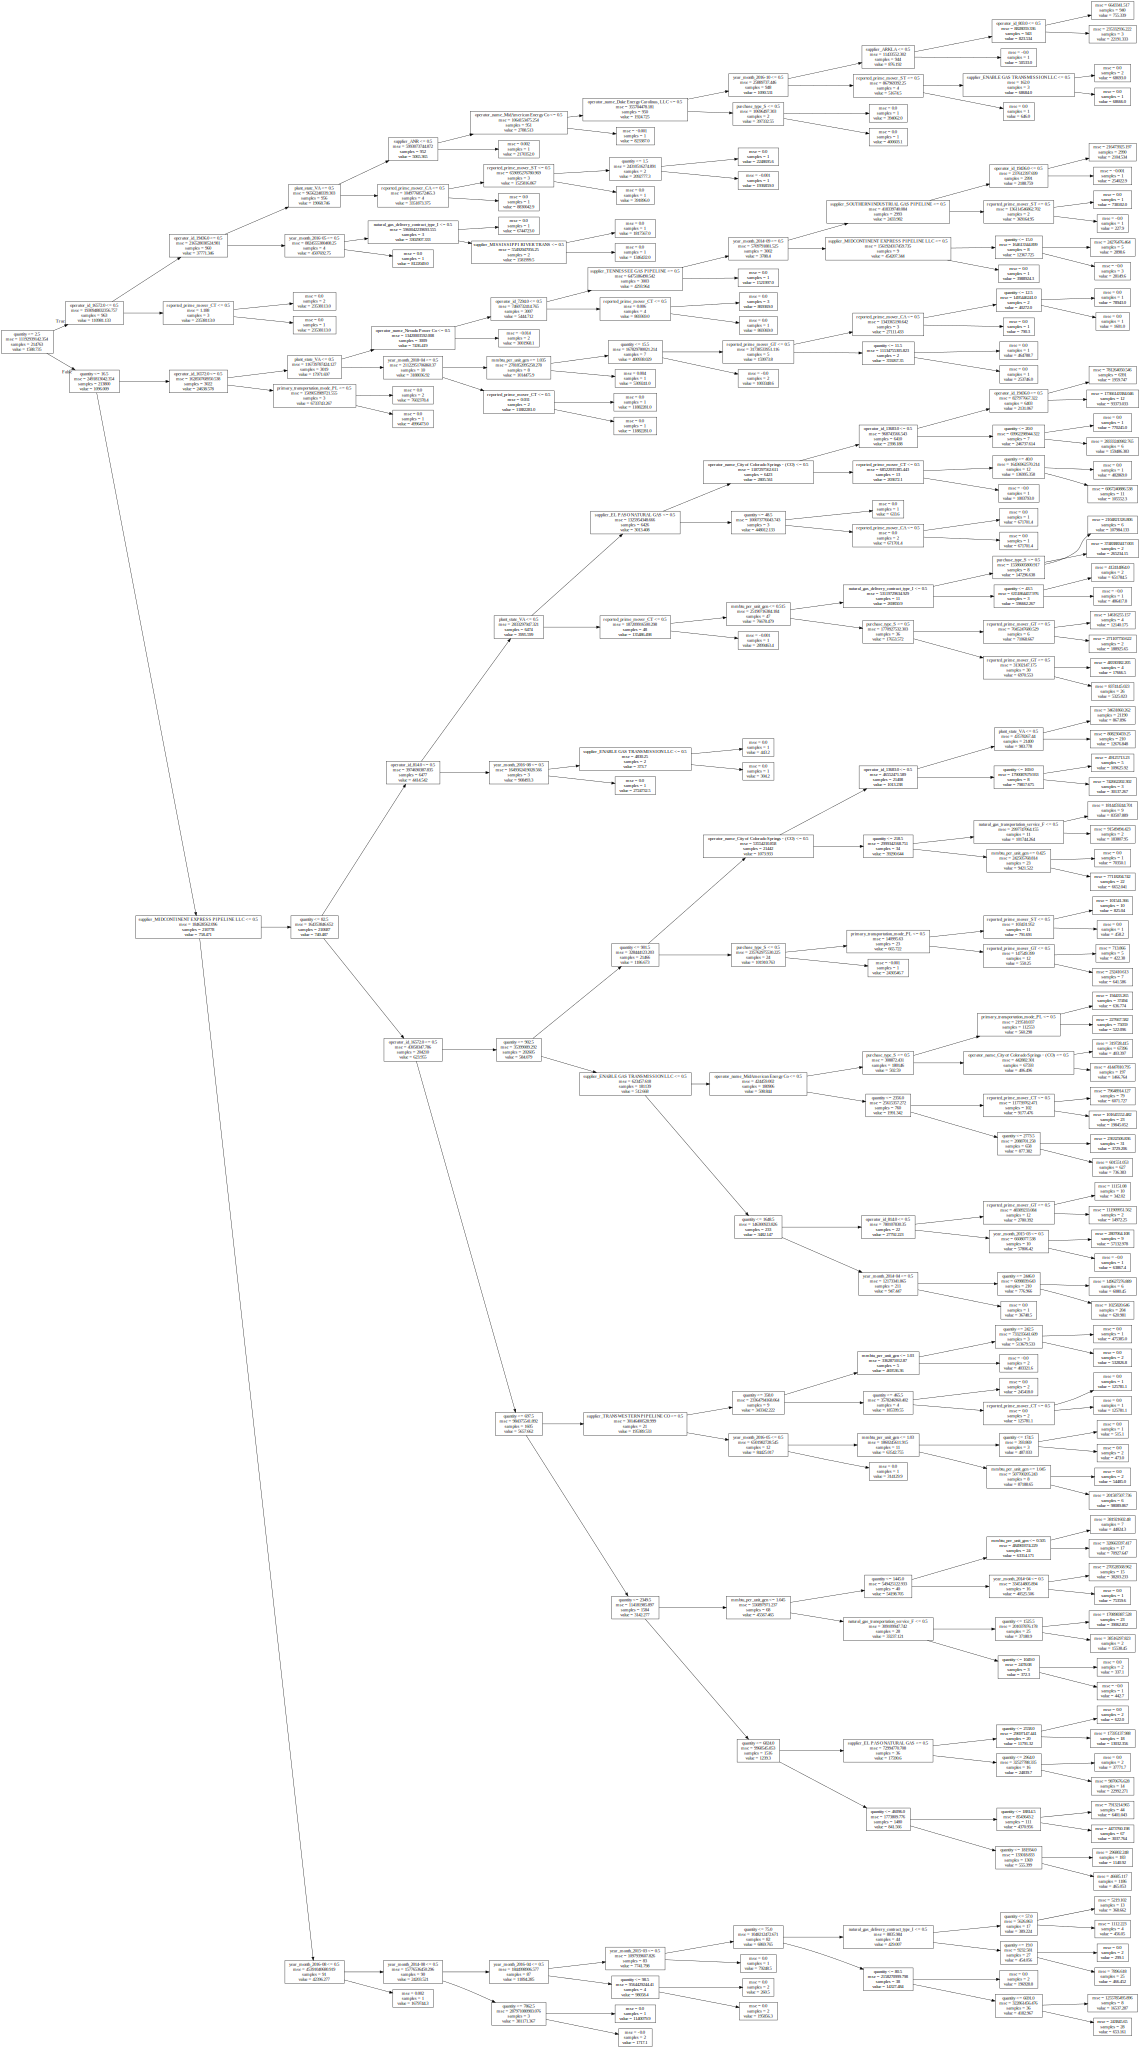

In [199]:
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
graph = Source(export_graphviz(results, rotate=True, out_file=None, feature_names=X.columns))
SVG(graph.pipe(format='svg'))

In [200]:
graph.format = 'png'
graph.render('dtree_render_h',view=True)

'dtree_render_h.png'

In [139]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

operator_id_16572.0 0.7455673180442225
year_month_2018-04 0.07885021075949052
plant_state_VA 0.061047934445932484
operator_id_19436.0 0.033554929465878285
reported_prime_mover_CA 0.01669629632740949
mmbtu_per_unit_gen 0.00903947423182198
natural_gas_delivery_contract_type_I 0.007598053847840813
operator_name_Nevada Power Co 0.007488171333737557
quantity 0.007368481798263049
year_month_2016-05 0.007291765237000717
supplier_MIDCONTINENT EXPRESS PIPELINE LLC 0.00593076255433258
reported_prime_mover_CT 0.003546245430749169
year_month_2016-08 0.003195648441148687
purchase_type_S 0.0023854183417931214
supplier_ANR 0.001958332427049443
primary_transportation_mode_PL 0.0018891080640075274
operator_id_7294.0 0.001247350909602333
operator_id_814.0 0.0010305003877058149
supplier_TENNESSEE GAS PIPELINE 0.0009614294997313059
reported_prime_mover_ST 0.0009197776993939002
year_month_2014-09 0.0007641506229105693
operator_name_MidAmerican Energy Co 0.00028196607891629616
supplier_EL PASO NATURAL GAS 0

In [191]:
df_16572 = df[df["operator_id"] == 16572]


In [192]:
grouped = df.groupby("year_month").mean()

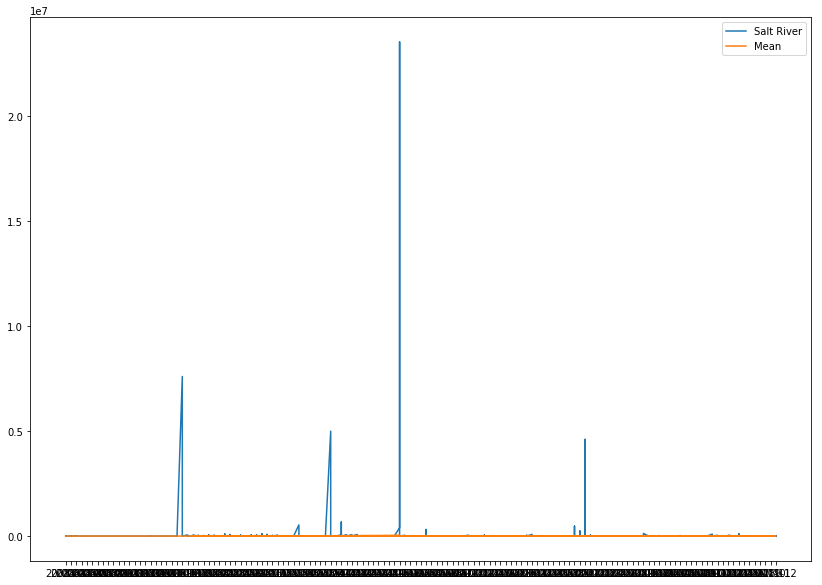

In [195]:
fig = plt.figure(figsize=(14,10))
plt.plot(df_16572["year_month"], df_16572["fuel_cost"], label="Salt River")
plt.plot(grouped.index, grouped["fuel_cost"], label="Mean")
plt.legend()

### Lots of features so sorting by largest coefficients

In [259]:
sorted(results.params.items(),key=lambda x: x[1], reverse=True)[0:50]

[('supplier_CEMEX', 675.675764749041),
 ('coalmine_msha_id_4608247.0', 487.5381454550442),
 ('supplier_ECI/VENEZUELA', 455.6097762690006),
 ('supplier_SPECIALIZED FUELS LLC', 407.84598254320866),
 ('supplier_CALENTURITAS', 357.70133693360424),
 ('coalmine_county_ 95', 344.13288653045834),
 ('supplier_GENESIS CONSULTING', 340.1222122504805),
 ('coalmine_state_ID', 334.5170586267999),
 ('coalmine_msha_id_1518922.0', 314.9922012874162),
 ('supplier_VIRGINIA ELEC', 289.898324124297),
 ('supplier_GUASARE', 272.7152310149398),
 ('coalmine_msha_id_4407180.0', 270.9280407140242),
 ('coalmine_msha_id_3600958.0', 266.20056712557147),
 ('coalmine_msha_id_4202028.0', 257.36321773931076),
 ('coalmine_msha_id_1202414.0', 256.6325105119255),
 ('supplier_TONYS FORK', 255.2222177371772),
 ('supplier_ELK MOUNTAIN', 246.94564836905832),
 ('supplier_NEW RIVER', 240.83547555148024),
 ('supplier_STONE COAL', 240.53249980373414),
 ('coalmine_county_65.0', 238.0394638775868),
 ('supplier_FOUNDATION ENERGY SAL

In [255]:
df[df["supplier"] == "CEMEX"][["fuel_cost", "year_month"]]
# mexican cement manufacturer with only one entry during polar vortex

,fuel_cost,year_month
247957,1052.2,2014-02


In [256]:
#GENESIS CONSULTING
df[df["supplier"] == "GENESIS CONSULTING"][["fuel_cost", "year_month"]]

,fuel_cost,year_month
49883,665.9,2008-08


### Some of these suppliers with large coefs only supplied for one year, when prices were high

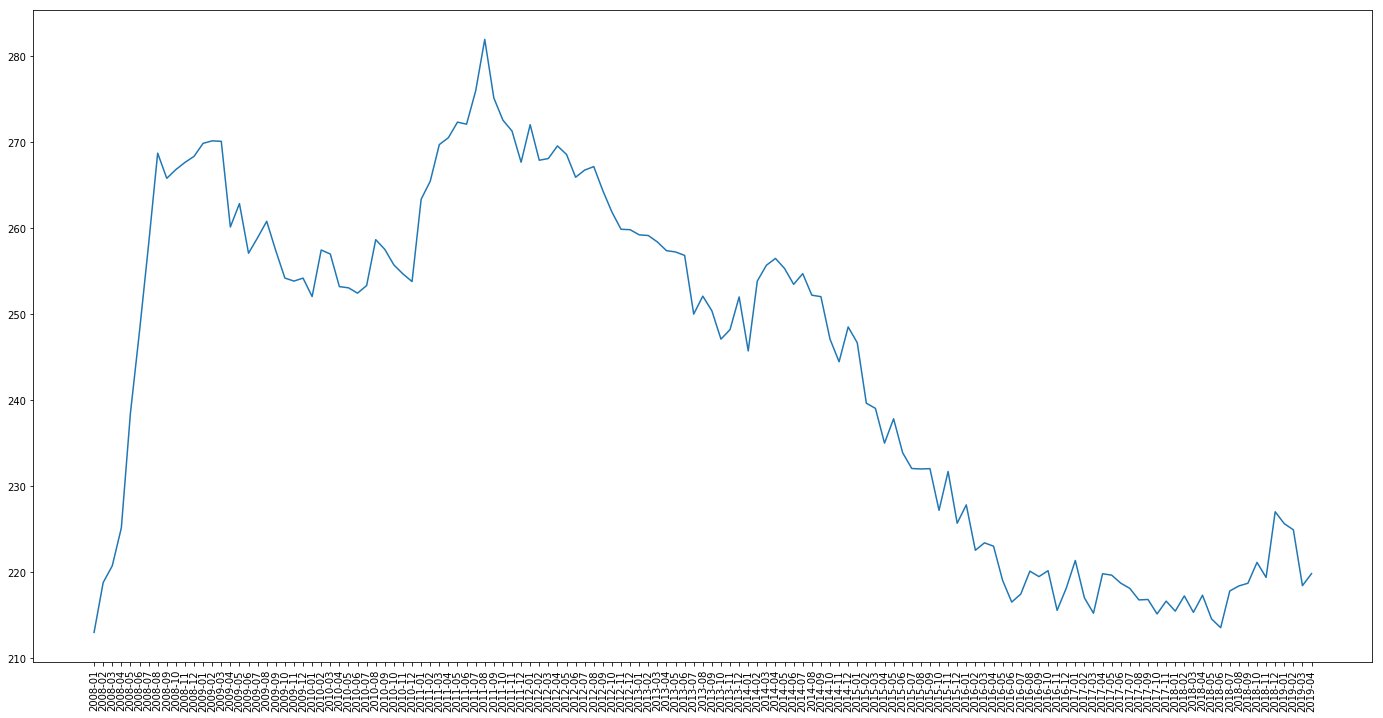

In [258]:
grouped_mean = df[df["fuel_group"] == "Coal"].groupby("year_month").mean()
fig = plt.figure(figsize=(24,12))
plt.xticks(rotation=90)
plt.plot(grouped_mean.index, grouped_mean["fuel_cost"])

### Another model, without suppliers

In [263]:
df_c = df[df["fuel_group"] == "Coal"].copy()
df_c.coalmine_msha_id = df_c.coalmine_msha_id.fillna(value="N/A")
df_c.chlorine_content = df_c.chlorine_content.fillna(value=0)
df_c.average_mercury_content = df_c.average_mercury_content.fillna(value=0)
df_c.moisture_content = df_c.moisture_content.fillna(value=df_c.moisture_content.median())

In [266]:
to_encode2 = to_encode
to_encode2.remove("supplier")
temp1 = df_c[not_encode].reset_index()
temp2 = pd.get_dummies(df_c[to_encode2]).reset_index()
df_c = temp1.merge(temp2, on="index").set_index("index")

In [267]:
X = df_c.drop(columns="fuel_cost")
y = df_c.fuel_cost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = OLS(y_train,X_train)
results = model.fit()

In [268]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              fuel_cost   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     191.8
Date:                Thu, 18 Jul 2019   Prob (F-statistic):               0.00
Time:                        14:22:46   Log-Likelihood:            -5.8602e+05
No. Observations:              110054   AIC:                         1.175e+06
Df Residuals:                  108519   BIC:                         1.190e+06
Df Model:                        1534                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
average_ash_content                 -0.4267      0.138     -3.087      0.002      -0.698      -0.156
average_heat_content                 5.9747      0.338     17.675      0.000       5.312       6.637
average_mercury_content             -0.2956      0.154     -1.913      0.056      -0.598       0.007
average_sulfur_content              -9.1343      0.539    -16.941      0.000     -10.191      -8.078
chlorine_content                 -3.893e-05   1.68e-05     -2.319      0.020   -7.18e-05   -6.02e-06
moisture_content                     0.0058      0.000     13.563      0.000       0.005       0.007
plant_id                          2.639e-05   3.92e-05      0.673      0.501   -5.05e-05       0.000
quantity                         -3.989e-05   3.18e-06    -12.544      0.000   -4.61e-05   -3.37e-05
net_generation_megawatthours     -1.441e-06   4.79e-08    -30.058      0.000   -1.53e-06   -1.35e-06
mmbtu_per_unit_gen                   0.1073      0.039      2.777      0.005       0.032       0.183
coalmine_county_  3                 42.0025     25.505      1.647      0.100      -7.987      91.992
coalmine_county_  5                 43.2316      4.633      9.332      0.000      34.151      52.312
coalmine_county_  9                 94.6693     14.415      6.567      0.000      66.416     122.923
coalmine_county_ 13                -18.9772     35.714     -0.531      0.595     -88.976      51.021
coalmine_county_ 19                 45.5877     14.229      3.204      0.001      17.699      73.476
coalmine_county_ 25                -43.2076     19.257     -2.244      0.025     -80.951      -5.464
coalmine_county_ 27                 49.7667     29.511      1.686      0.092      -8.075     107.609
coalmine_county_ 29                -84.6049     16.601     -5.096      0.000    -117.142     -52.068
coalmine_county_ 31                -34.1567     14.054     -2.430      0.015     -61.703      -6.611
coalmine_county_ 33               -119.2819     50.207     -2.376      0.018    -217.686     -20.878
coalmine_county_ 39                  1.2082      6.689      0.181      0.857     -11.902      14.318
coalmine_county_ 45                -17.2358      7.419     -2.323      0.020     -31.776      -2.695
coalmine_county_ 47                -71.1063     29.118     -2.442      0.015    -128.177     -14.035
coalmine_county_ 51               -104.9369     50.218     -2.090      0.037    -203.363      -6.511
coalmine_county_ 53                -53.0895     14.339     -3.702      0.000     -81.194     -24.984
coalmine_county_ 59                 85.5362      9.970      8.580      0.000      65.996     105.077
coalmine_county_ 61                 17.2966     22.675      0.763      0.446     -27.147      61.740
coalmine_county_ 65                 91.1423     37.90

In [269]:
sorted(results.params.items(),key=lambda x: x[1], reverse=True)[0:20]

[('coalmine_msha_id_4608247.0', 474.6145646021431),
 ('coalmine_state_ID', 401.79294240770173),
 ('coalmine_county_ 95', 311.7005924947425),
 ('coalmine_msha_id_1518267.0', 286.3889377028155),
 ('coalmine_msha_id_1518922.0', 285.22093865256545),
 ('coalmine_msha_id_4406505.0', 275.81412072050057),
 ('coalmine_msha_id_3600958.0', 264.20716609461346),
 ('coalmine_msha_id_4801694.0', 253.04929700306818),
 ('coalmine_msha_id_1519075.0', 225.92220064116393),
 ('coalmine_msha_id_1518196.0', 224.60013990209475),
 ('coalmine_msha_id_4003199.0', 212.2309901762902),
 ('coalmine_msha_id_1517880.0', 208.13301287496438),
 ('coalmine_msha_id_4003213.0', 206.6278138107151),
 ('coalmine_msha_id_4407180.0', 205.9404146856818),
 ('coalmine_msha_id_4608767.0', 199.9232955539448),
 ('operator_id_19856.0', 199.48566385359754),
 ('plant_state_NJ', 199.48566385359675),
 ('coalmine_msha_id_1102797.0', 186.89171516330669),
 ('coalmine_msha_id_4406822.0', 185.3119924482945),
 ('coalmine_msha_id_4202028.0', 183.

In [270]:
df[df["coalmine_msha_id"] == 4608247.0][["fuel_cost", "year_month"]]

,fuel_cost,year_month
52960,772.8,2008-08
60504,774.4,2008-09


### Examining only those with chlorine values defined since there was such a high correlation with fuel_cost

In [229]:
df_c = df[(df["fuel_group"] == "Coal") & (df["chlorine_content"].notna())].copy()

In [230]:
df_c.coalmine_msha_id = df_c.coalmine_msha_id.fillna(value="N/A")

In [203]:
df_c.isna().sum()

fuel_cost                         0
average_ash_content               0
average_heat_content              0
average_mercury_content           0
average_sulfur_content            0
chlorine_content                  0
moisture_content                  0
plant_id                          0
quantity                          0
net_generation_megawatthours      0
mmbtu_per_unit_gen                0
coalmine_msha_id                381
coalmine_county_1                 0
coalmine_county_103               0
coalmine_county_105               0
coalmine_county_107               0
coalmine_county_109               0
coalmine_county_11                0
coalmine_county_115               0
coalmine_county_117               0
coalmine_county_119               0
coalmine_county_121               0
coalmine_county_125               0
coalmine_county_127               0
coalmine_county_13                0
coalmine_county_131               0
coalmine_county_133               0
coalmine_county_135         

In [231]:
temp1 = df_c[not_encode].reset_index()
temp2 = pd.get_dummies(df_c[to_encode]).reset_index()
#df_c = df_c[not_encode].reset_index()
df_c = temp1.merge(temp2, on="index").set_index("index")

In [211]:
X = df_c.drop(columns="fuel_cost")
y = df_c.fuel_cost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = OLS(y_train,X_train)
results = model.fit()

In [212]:
results.summary()

/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              fuel_cost   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     53.11
Date:                Thu, 18 Jul 2019   Prob (F-statistic):               0.00
Time:                        13:27:54   Log-Likelihood:                -34696.
No. Observations:                7284   AIC:                         7.061e+04
Df Residuals:                    6675   BIC:                         7.481e+04
Df Model:                         608                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
average_ash_content                                      -2.0502      0.611     -3.354      0.001      -3.249      -0.852
average_heat_content                                     -5.1414      1.432     -3.589      0.000      -7.949      -2.333
average_mercury_content                                   4.0326      1.893      2.130      0.033       0.322       7.743
average_sulfur_content                                    3.1412      2.526      1.244      0.214      -1.810       8.092
chlorine_content                                      -3.984e-05   1.87e-05     -2.128      0.033   -7.66e-05   -3.13e-06
moisture_content                                          0.0012      0.001      1.722      0.085      -0.000       0.003
plant_id                                                  0.0011   9.27e-05     11.719      0.000       0.001       0.001
quantity                                              -7.665e-06   7.91e-06     -0.969      0.333   -2.32e-05    7.84e-06
net_generation_megawatthours                          -2.583e-07   1.91e-07     -1.353      0.176   -6.33e-07    1.16e-07
mmbtu_per_unit_gen                                       -0.0335      0.097     -0.345      0.730      -0.224       0.157
coalmine_county_1                                        -6.5276     13.432     -0.486      0.627     -32.859      19.803
coalmine_county_103                                     -24.2793      8.584     -2.828      0.005     -41.107      -7.452
coalmine_county_105                                      40.0802     13.098      3.060      0.002      14.403      65.757
coalmine_county_107                                     -14.4476     11.842     -1.220      0.223     -37.662       8.767
coalmine_county_109                                     -55.1934     12.466     -4.427      0.000     -79.631     -30.755
coalmine_county_11                                      -13.1466     17.908     -0.734      0.463     -48.253      21.959
coalmine_county_115                                     -14.4102     14.535     -0.991      0.322     -42.903      14.083
coalmine_county_117                                     -30.1392     12.255     -2.459      0.014     -54.164      -6.115
coalmine_county_119                                      25.7764     23.592      1.093      0.275     -20.472      72.025
coalmine_county_121                                     -23.7322      5.560     -4.268      0.000     -34.632     -12.832
coalmine_county_125                                     -14.4301     15.036     -0.960      0.337     -43.905      15.045
coalmine_county_127                                      29.0425     20.711      1.402      0.161     -11.557      69.642
coalmine_county_13               

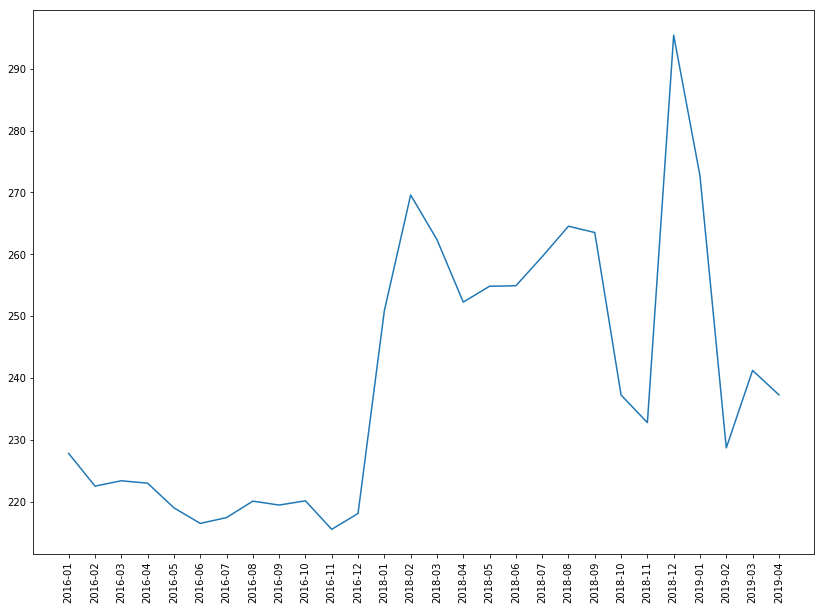

In [221]:
fig = plt.figure(figsize=(14,10))
plt.xticks(rotation=90)
grouped = df_c.groupby("year_month").mean()
grouped = grouped.sort_values("year_month", ascending=True)
plt.plot(grouped.index, grouped.fuel_cost)